# Implementation and example of various skill scores

In [1]:
import valenspy as vp
from valenspy._utilities import load_yml
from valenspy.preprocessing_tasks.select import select_point
from valenspy.diagnostic_functions import mean_bias, mean_absolute_error, root_mean_square_error, spearman_correlation, perkins_skill_score
from pathlib import Path


import xarray as xr
import numpy as np
import pandas as pd



# define machine name - used for paths of (observational) datasets
machine = 'hortense'

manager = vp.InputManager(machine=machine)


## 0. Settings

In [2]:
# define points to abstract (lon, lat)
d_point_coords = {
    'opwijk'    : (4.18, 50.97), 
    'betrix'    : (5.25, 49.854),
    'north_sea' : (2.465, 51.63),
}

point_id = "betrix"
point_coord = d_point_coords[point_id]

In [33]:
def load_point_exp_ref(variable, model, ref_dataset, experiments, point_coord):

    if variable == 'tasmin' or variable == 'tasmax': 
        variable_to_load = 'tas'
    else: 
        variable_to_load = variable    
    ds_obs = manager.load_data(ref_dataset, variable_to_load, period=[1995,1995], freq="hourly", region="europe")

    if variable in ['tas','clt', 'clh', 'clm', 'cll', 'psl']:
        daily_statistic = "mean"
        ds_obs = ds_obs.resample(time='1D').mean()

    elif variable == 'pr': 
 
        daily_statistic = "sum"
        ds_obs = ds_obs.resample(time='1D').mean()

    elif variable == "tasmax": 
        daily_statistic = "max"
        ds_obs = ds_obs.resample(time='1D').max()

    elif variable == "tasmin": 
        daily_statistic = "min"
        ds_obs = ds_obs.resample(time='1D').min()       
        

    # for both datasets, select summer months (JJA)
    ds_obs = ds_obs.sel(time=ds_obs.time.dt.month.isin([6,7,8]))

    # make sure both Datasets have the same daily time axis
    ds_obs['time'] = ds_obs['time'].dt.floor('D')

    # do point selection
    ds_obs_point = select_point(ds_obs, point_coord)

    da_obs = ds_obs_point[variable_to_load].compute()

    d_da_mod = {}
    for experiment in experiments: 

        if variable == 'tasmin' : 
            variable_to_load = 'tas'
            daily_statistic = 'min'
        elif variable =='tasmax': 
            variable_to_load = 'tas'
            daily_statistic = 'max'
        else: 
            variable_to_load = variable
        ds_mod = manager.load_data(model, [variable_to_load], freq="daily", path_identifiers=[experiment, daily_statistic])

        ds_mod = ds_mod.sel(time=ds_mod.time.dt.month.isin([6,7,8]))

        ds_mod['time'] = ds_mod['time'].dt.floor('D')

        ds_mod_point = select_point(ds_mod, point_coord, rotated_pole=True)

        da_mod = ds_mod_point[variable_to_load].compute()

        d_da_mod[experiment] = da_mod

    return da_obs,d_da_mod




## 2. Skill score calculations
in this example, this means selecting the point data and corresponding time

In [4]:
def get_userdefined_binwidth(variable):
    
    # define bin width lookup table
    d_binwidth = { 
    'tas'    : 2,
    'tasmax' : 2,
    'tasmin' : 2,
    'ps'     : 500,
    'psl'    : 500,
    'clt'    : 10,
    'clh'    : 10,
    'clm'    : 10,
    'cll'    : 10 }

    if variable in d_binwidth: 
        return d_binwidth[variable]
    else:

        print(f"{variable} has no defined binwidths")




In [5]:
def calc_metrics(experiments: list, d_da_mod: dict, da_obs: xr.DataArray):
    """
    Calculates multiple statistical metrics for each experiment by comparing model data with observed data.

    This function computes various performance metrics for each experiment in `experiments` by comparing
    the corresponding model data (from `d_da_mod`) against the observed data (`da_obs`). The calculated
    metrics include bias, errors at different percentiles, correlation, and skill score. The results are
    returned as a DataFrame where each row corresponds to a metric, and each column corresponds to an experiment.

    The metrics calculated are:
    - Mean Bias
    - Mean Absolute Error
    - Mean Absolute Error at the 90th, 99th, 10th, and 1st percentiles
    - Root Mean Square Error (RMSE)
    - Spearman Correlation
    - Perkins Skill Score

    Parameters
    ----------
    experiments : list
        A list of experiment names for which metrics will be calculated.
    d_da_mod : dict
        A dictionary of `xarray.DataArray` objects where each key is an experiment name, and the value
        is the corresponding model data for that experiment.
    da_obs : xarray.DataArray
        The observed data that will be used for comparison with the model data.
    
    Returns
    -------
    pandas.DataFrame
        A DataFrame where each row corresponds to a metric, the first column contains the metric names, and
        each subsequent column contains the calculated metric values for the corresponding experiment.

    Notes
    -----
    - The `binwidth` used in the Perkins Skill Score is defined by the user through the `get_userdefined_binwidth` function.
    - The function assumes that helper functions such as `mean_bias`, `mean_absolute_error`, `root_mean_square_error`,
      `spearman_correlation`, and `perkins_skill_score` are predefined and available.
    - The structure of the DataFrame grows by merging metrics data for each experiment in `experiments`.

    """

    for i, experiment in enumerate(experiments): 
        da_mod = d_da_mod[experiment]
        # Calculate metrics
        bias = mean_bias(da_mod, da_obs)
        mae = mean_absolute_error(da_mod, da_obs)
        mae_90pctl = mean_absolute_error(da_mod, da_obs, percentile=0.9)
        mae_99pctl = mean_absolute_error(da_mod, da_obs, percentile=0.99)
        mae_10pctl = mean_absolute_error(da_mod, da_obs, percentile=0.1)
        mae_1pctl = mean_absolute_error(da_mod, da_obs, percentile=0.01)
        rmse = root_mean_square_error(da_mod, da_obs)
        corr = spearman_correlation(da_mod, da_obs)
        binwidth = get_userdefined_binwidth(variable)  # Replace `None` with actual variable if needed
        pss, _, _, _ = perkins_skill_score(da_mod, da_obs, binwidth=binwidth)


        # Create a dictionary with the metrics and their values
        metrics_data = {
            "metric": [
                "Mean Bias",
                "Mean Absolute Error",
                "MAE at 90th Percentile",
                "MAE at 99th Percentile",
                "MAE at 10th Percentile",
                "MAE at 1st Percentile",
                "Root Mean Square Error",
                "Spearman Correlation",
                "Perkins Skill Score"
            ],
            experiment: [
                bias,
                mae,
                mae_90pctl,
                mae_99pctl,
                mae_10pctl,
                mae_1pctl,
                rmse,
                corr,
                pss
            ]
        }

        # Create a DataFrame
        if i == 0:
            df_metric = pd.DataFrame(metrics_data)
        else: 
            df_metric = pd.merge(df_metric, pd.DataFrame(metrics_data) )
    
    #df_metric_rank = df_metric.set_index('metric').rank(axis=1)
    return df_metric


In [6]:
def get_ranks_metrics(df: pd.DataFrame): 
    """
    Ranks the performance of different models across various metrics based on predefined ranking criteria.

    This function applies custom ranking rules to evaluate the performance of models across different metrics.
    The ranking is based on the following criteria:
    
    - 'Mean Bias' is ranked by its absolute value, with smaller values (closer to zero) ranked higher.
    - 'Spearman Correlation' and 'Perkins Skill Score' are ranked in descending order, meaning higher values (closer to 1) are better.
    - All other metrics are ranked in ascending order, where lower values are better.
    
    The input DataFrame `df` is expected to have the following structure:
    - The first column contains the metric names.
    - Each subsequent column contains the performance values of different models for each metric.
    
    Parameters
    ----------
    df : pandas.DataFrame
        A DataFrame where each row corresponds to a metric, the first column is the metric name, 
        and the subsequent columns contain performance values for different models.
    
    Returns
    -------
    pandas.DataFrame
        A DataFrame where each value is replaced by its rank based on the ranking criteria for the corresponding metric.
        The rows are indexed by the metric names.
    
    """

    # Function to rank values
    def rank_values(row):

        if row['metric'] == 'Mean Bias':
            return row[1:].abs().rank(ascending=True)

        if row['metric'] in ['Spearman Correlation', 'Perkins Skill Score']:
            return row[1:].rank(ascending=False, method='min')
        else:
            return row[1:].rank(ascending=True, method='min')

    # Apply ranking
    df_ranked = df.apply(rank_values, axis=1).set_index(df['metric'])

    return df_ranked


In [21]:
ref_dataset = 'ERA5'
variables = ['tas', 'clt', 'pr' ]
model = 'CCLM'
# "EUR11_NU_TT_EC_TSO",
experiments = [ "BE28_Nick", "BE28_Nukleus_3h", "BE28_Ruben"]

d_df_metric_rank = {}
d_df_metric = {}
for variable in variables: 
    da_obs, d_da_mod =  load_point_exp_ref(variable, model, ref_dataset, experiments, point_coord)
    
    df_metric = calc_metrics(experiments, d_da_mod, da_obs)
    df_metric_rank = get_ranks_metrics(df_metric)

    d_df_metric_rank[variable] =  df_metric_rank
    d_df_metric[variable] =  df_metric

File paths found:
/dodrio/scratch/projects/2022_200/project_input/External/observations/era5/europe/2m_temperature/hourly/era5-hourly-europe-2m_temperature-1995.nc
The file is ValEnsPy CF compliant.
100.00% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['tas']


KeyboardInterrupt: 

/tmp/ipykernel_3970814/2573443009.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('summer', num_levels)


KeyError: 'tas'

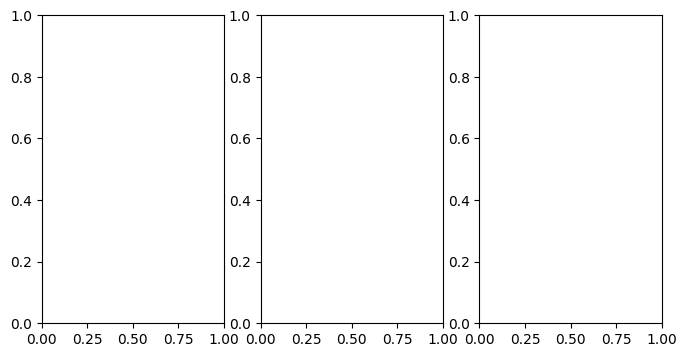

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import numpy as np
from valenspy._utilities import load_yml

CORDEX_lookup = load_yml('CORDEX_variables')


# Define the number of levels based on the length of experiments
num_levels = len(experiments)

# Get the 'summer' colormap with the required number of discrete levels
cmap = cm.get_cmap('summer', num_levels)

# Define boundaries and normalization for the number of levels
boundaries = np.arange(1, num_levels + 2, 1)  # Create boundaries based on the number of levels
norm = mcolors.BoundaryNorm(boundaries, cmap.N, clip=True)

fig, axes = plt.subplots(1,len(variables), figsize=(8,4))
axes = axes.flatten()

for i,variable in enumerate(variables): 
    ax = axes[i]

    if i == 0: 
        sns.heatmap(d_df_metric_rank[variable], ax=ax,cbar=False,  cmap=cmap, norm=norm)
        ax.set_ylabel(' ')

    else:
        heatmap = sns.heatmap(d_df_metric_rank[variable], ax=ax,  cbar=True,  cmap=cmap, norm=norm)
        colorbar = heatmap.collections[0].colorbar
        colorbar.set_ticks(np.arange(1,len(experiments)+1)+.5)  # Set the ticks you want
        colorbar.set_ticklabels(range(1,len(experiments)+1))  # Set the custom labels for the ticks

        ax.set_yticks([])
        ax.set_ylabel(' ')
    
    ax.set_title(variable, loc='right')

fig.tight_layout()

In [34]:
ref_dataset = 'ERA5'
variables = ['tasmax', 'tasmin', 'psl' ]
model = 'CCLM'
# "EUR11_NU_TT_EC_TSO",
experiments = [ "BE28_Nick", "BE28_Nukleus_3h", "BE28_Ruben"]

d_df_metric_rank = {}
d_df_metric = {}
for variable in variables: 
    da_obs, d_da_mod =  load_point_exp_ref(variable, model, ref_dataset, experiments, point_coord)
    
    df_metric = calc_metrics(experiments, d_da_mod, da_obs)
    df_metric_rank = get_ranks_metrics(df_metric)

    d_df_metric_rank[variable] =  df_metric_rank
    d_df_metric[variable] =  df_metric

File paths found:
/dodrio/scratch/projects/2022_200/project_input/External/observations/era5/europe/2m_temperature/hourly/era5-hourly-europe-2m_temperature-1995.nc
The file is ValEnsPy CF compliant.
100.00% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['tas']
File paths found:
/dodrio/scratch/projects/2022_200/RCS/CORDEXBE2/postprocessing/BE28_Nick/T_2M/daily/T_2M_daymax.nc
Variable metadata is missing or incorrect
The file is NOT ValEnsPy CF compliant.
33.33% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['tas']
Unknown to ValEnsPy: ['time_bnds', 'rotated_pole']
File paths found:
/dodrio/scratch/projects/2022_200/RCS/CORDEXBE2/postprocessing/BE28_Nukleus_3h/T_2M/daily/T_2M_daymax.nc
Variable metadata is missing or incorrect
The file is NOT ValEnsPy CF compliant.
33.33% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['tas']
Unknown to ValEnsPy: ['time_bnds', 'rotated_pole']
File paths found:
/dodrio/scratch/projects/2022_200/R

/tmp/ipykernel_3970814/2573443009.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('summer', num_levels)


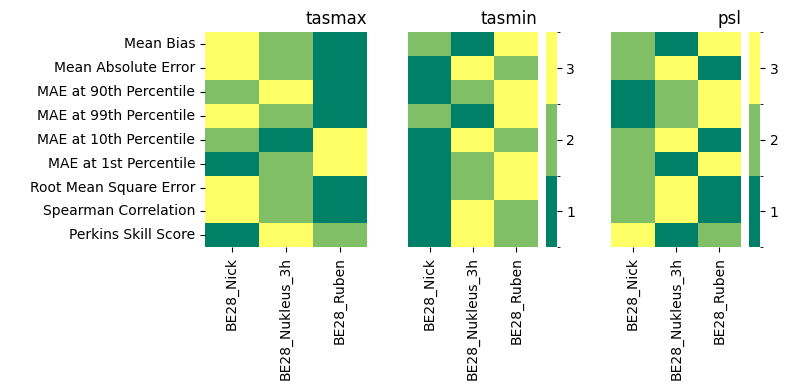

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import numpy as np
from valenspy._utilities import load_yml

CORDEX_lookup = load_yml('CORDEX_variables')


# Define the number of levels based on the length of experiments
num_levels = len(experiments)

# Get the 'summer' colormap with the required number of discrete levels
cmap = cm.get_cmap('summer', num_levels)

# Define boundaries and normalization for the number of levels
boundaries = np.arange(1, num_levels + 2, 1)  # Create boundaries based on the number of levels
norm = mcolors.BoundaryNorm(boundaries, cmap.N, clip=True)

fig, axes = plt.subplots(1,len(variables), figsize=(8,4))
axes = axes.flatten()

for i,variable in enumerate(variables): 
    ax = axes[i]

    if i == 0: 
        sns.heatmap(d_df_metric_rank[variable], ax=ax,cbar=False,  cmap=cmap, norm=norm)
        ax.set_ylabel(' ')

    else:
        heatmap = sns.heatmap(d_df_metric_rank[variable], ax=ax,  cbar=True,  cmap=cmap, norm=norm)
        colorbar = heatmap.collections[0].colorbar
        colorbar.set_ticks(np.arange(1,len(experiments)+1)+.5)  # Set the ticks you want
        colorbar.set_ticklabels(range(1,len(experiments)+1))  # Set the custom labels for the ticks

        ax.set_yticks([])
        ax.set_ylabel(' ')
    
    ax.set_title(variable, loc='right')

fig.tight_layout()

## Skill scores overview

In [87]:
from IPython.display import Markdown, display



# Print metrics in Markdown table format

# Create Markdown table with dynamic values
markdown_table = f"""
Metrics for **{da_mod.long_name}** ({variable})

{experiment} compared to {ref_dataset}

| Metric                   |       |
|--------------------------|------------|
| Mean Bias                | {bias:.2f} {da_mod.units}  |
| Mean Absolute Error      | {mae:.2f} {da_mod.units}  |
| MAE at 90th Percentile    | {mae_90pctl:.2f} {da_mod.units}  |
| MAE at 99th Percentile    | {mae_99pctl:.2f} {da_mod.units}  |
| MAE at 10th Percentile    | {mae_10pctl:.2f} {da_mod.units} |
| MAE at 1st Percentile     | {mae_1pctl:.2f} {da_mod.units} |
| Root Mean Square Error   | {rmse:.2f} {da_mod.units}  |
| Spearman Correlation     | {corr:.2f}   |
| Perkins Skill Score      | {pss:.2f}   |
"""

# Display Markdown in the notebook
display(Markdown(markdown_table))


Metrics for **Near-Surface Air Temperature** (clt)

BE28_Ruben compared to ERA5

| Metric                   |       |
|--------------------------|------------|
| Mean Bias                | -1.00 K  |
| Mean Absolute Error      | 1.44 K  |
| MAE at 90th Percentile    | 1.09 K  |
| MAE at 99th Percentile    | 1.93 K  |
| MAE at 10th Percentile    | 1.14 K |
| MAE at 1st Percentile     | 0.54 K |
| Root Mean Square Error   | 1.83 K  |
| Spearman Correlation     | 0.92   |
| Perkins Skill Score      | 0.86   |
